In [2]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'serif'

In [3]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [4]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='GBR'

def model(co2_constraint):
      network = pypsa.Network()
      hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                                    '2015-12-31 23:00Z',
                                    freq='h')

      network.set_snapshots(hours_in_2015.values)

      network.add("Bus",
                  "electricity bus")
      # add load to the bus
      network.add("Load",
                  "load",
                  bus="electricity bus",
                  p_set=df_elec[country].values)
      
      # CAPEX values for different technologies (in €/MW)
      offshoreWind_capex = 2.8e6
      onshoreWind_capex = 1.4e6
      solar_capex = 628e3
      ccgt_capex = 1.04e6
      nuclear_capex = 11.08e6
      electrolyzer_capex = 350e3
      h2_tank_capex = 8.4e3
      fuel_cell_capex = 339e3

      # add the different carriers, only gas emits CO2
      network.add("Carrier", "gas", co2_emissions=0.2019) # in t_CO2/MWh_th
      network.add("Carrier", "onshorewind")
      network.add("Carrier", "solar")

      # add onshore wind generator
      df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
      df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
      CF_windOnshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
      capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex #*(1+0.033) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      network.add("Generator",
                  "onshorewind",
                  bus="electricity bus",
                  p_nom_extendable=True,
                  carrier="onshorewind",
                  #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                  capital_cost = capital_cost_onshorewind,
                  marginal_cost = 0,
                  p_max_pu = CF_windOnshore.values)

      # add offshore wind generator
      df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
      df_offshore.index = pd.to_datetime(df_offshore.index)
      CF_windOffshore = df_offshore[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
      capital_cost_offshore = annuity(25,0.07)*offshoreWind_capex *(1+0.03) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      network.add("Generator",
                  "offshorewind",
                  bus="electricity bus",
                  p_nom_extendable=True,
                  carrier="offshorewind",
                  #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                  capital_cost = capital_cost_offshore,
                  marginal_cost = 0,
                  p_max_pu = CF_windOffshore.values)

      # add solar PV generator
      df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
      df_solar.index = pd.to_datetime(df_solar.index)
      CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
      capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
      network.add("Generator",
                  "solar",
                  bus="electricity bus",
                  p_nom_extendable=True,
                  carrier="solar",
                  #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                  capital_cost = capital_cost_solar,
                  marginal_cost = 0,
                  p_max_pu = CF_solar.values)

      # add CCGT (Combine Cycle Gas Turbine) generator
      capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
      fuel_cost = 30.32 # in €/MWh_th
      efficiency = 0.5 # MWh_elec/MWh_th
      marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
      network.add("Generator",
                  "CCGT",
                  bus="electricity bus",
                  p_nom_extendable=True,
                  carrier="gas",
                  #p_nom_max=1000,
                  capital_cost = capital_cost_CCGT,
                  marginal_cost = marginal_cost_CCGT)

      # add nuclear generator
      capital_cost_nuclear = annuity(30,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
      fuel_cost = 6.2 # in €/MWh_th
      efficiency = 0.33 # MWh_elec/MWh_th
      marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el
      network.add("Generator",
                  "nuclear",
                  bus="electricity bus",
                  p_nom_extendable=True,
                  carrier="nuclear",
                  #p_nom_max=1000,
                  capital_cost = capital_cost_nuclear,
                  marginal_cost = marginal_cost_nuclear)
      
      # NEW ADDITION: Hydrogen storage
      #Create a new carrier
      network.add("Carrier",
                  "H2")

      #Create a new bus
      network.add("Bus",
                  "H2",
                  carrier = "H2")

      #Connect the store to the bus
      network.add("Store",
            "H2 Tank",
            bus = "H2",
            e_nom_extendable = True,
            e_cyclic = True,
            capital_cost = annuity(20, 0.07)*h2_tank_capex*(1+0))

            #Add the link "H2 Electrolysis" that transport energy from the electricity bus (bus0) to the H2 bus (bus1)
            #with 80% efficiency
      network.add("Link",
            "H2 Electrolysis",
            bus0 = "electricity bus",
            bus1 = "H2",
            p_nom_extendable = True,
            efficiency = 0.8,
            capital_cost = annuity(20, 0.07)*electrolyzer_capex*(1+0.04))

            #Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
            #with 58% efficiency
      network.add("Link",
            "H2 Fuel Cell",
            bus0 = "H2",
            bus1 = "electricity bus",
            p_nom_extendable = True,
            efficiency = 0.58,
            capital_cost = annuity(18, 0.07)*fuel_cell_capex*(1+0.03))
      
            # CO2 Constraint
      network.add("GlobalConstraint",
                  "co2_limit",
                  type="primary_energy",
                  carrier_attribute="co2_emissions",
                  sense="<=",
                  constant=co2_constraint)
      network.optimize(solver_name='gurobi', solver_options={"LogToConsole": 0})
      
      return network



In [5]:
co2_limit=100000000 #tonCO2
network = model(co2_limit)


Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 64.35it/s]
INFO:linopy.io: Writing time: 0.78s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-2k9g8f4h.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-2k9g8f4h.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 2.05e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [6]:
print(network.objective/1000000) #in 10^6 €

20504.575110017773


In [7]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    72.660966
dtype: float64


In [8]:
network.generators.p_nom_opt # in MW

Generator
onshorewind     52801.147228
offshorewind        0.000000
solar            1412.630841
CCGT            44541.713521
nuclear             0.000000
Name: p_nom_opt, dtype: float64

In [9]:
# Get the installed capacity of the hydrogen tank
hydrogen_capacity = network.stores.loc['H2 Tank', 'e_nom_opt']  # in MWh
print(f"Installed hydrogen capacity: {hydrogen_capacity} MWh")

# Get the installed capacity of the electrolyzer
electrolyzer_capacity = network.links.loc['H2 Electrolysis', 'p_nom_opt']  # in MW
print(f"Installed electrolyzer capacity: {electrolyzer_capacity} MW")

# Get the installed capacity of the fuel cell
fuel_cell_capacity = network.links.loc['H2 Fuel Cell', 'p_nom_opt']  # in MW
print(f"Installed fuel cell capacity: {fuel_cell_capacity} MW")

Installed hydrogen capacity: 32211.527257859358 MWh
Installed electrolyzer capacity: 890.9926795464635 MW
Installed fuel cell capacity: 9043.498478925289 MW


Weekly plot

C:\Users\carlo\AppData\Local\Temp\ipykernel_38744\2535945089.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=num_hours_week * num_weeks, freq='H')


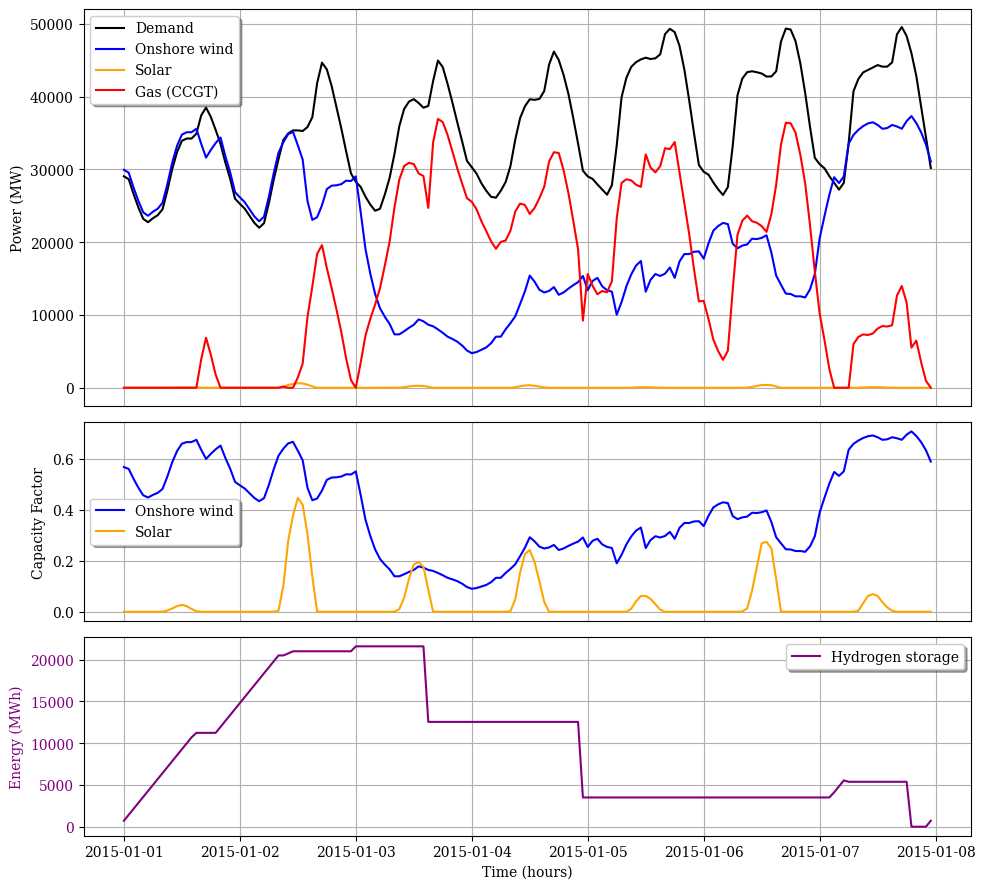

In [45]:
# Plot a week with hydrogen storage and capacity factors
num_hours_week = 7 * 24
num_weeks = 1
hours = pd.date_range(start="2015-01-01", periods=num_hours_week * num_weeks, freq='H')

demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values
hydrogen = network.stores_t.e['H2 Tank'][hours].values

# Calculate capacity factors
onshore_wind_cf = onshore_wind / network.generators.p_nom_opt['onshorewind']
solar_cf = solar / network.generators.p_nom_opt['solar']

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 9), gridspec_kw={'height_ratios': [2, 1, 1]})

# First subplot: Energy production and demand
axs[0].plot(hours, demand, color='black', label='Demand')
axs[0].plot(hours, onshore_wind, color='blue', label='Onshore wind')
axs[0].plot(hours, solar, color='orange', label='Solar')
axs[0].plot(hours, gas_ccgt, color='red', label='Gas (CCGT)')
# axs[0].plot(hours, offshore_wind, color='green', label='Offshore wind')
# axs[0].plot(hours, nuclear, color='brown', label='Nuclear')
axs[0].legend(fancybox=True, shadow=True, loc='upper left')
axs[0].set_ylabel('Power (MW)')
axs[0].grid(True)

# Remove x-axis ticks and labels for the first subplot
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Second subplot: Capacity factors
axs[1].plot(hours, onshore_wind_cf, color='blue', label='Onshore wind')
axs[1].plot(hours, solar_cf, color='orange', label='Solar')
axs[1].set_ylabel('Capacity Factor')
axs[1].legend(fancybox=True, shadow=True, loc='best')
axs[1].grid(True)

# Remove x-axis ticks and labels for the second subplot
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Third subplot: Hydrogen storage
axs[2].plot(hours, hydrogen, color='purple', label='Hydrogen storage')
axs[2].set_xlabel('Time (hours)')
axs[2].set_ylabel('Energy (MWh)', color='purple')
axs[2].tick_params(axis='y', labelcolor='purple')
axs[2].legend(fancybox=True, shadow=True, loc='upper right')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

Seasonal plot

C:\Users\carlo\AppData\Local\Temp\ipykernel_38744\2437467678.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=num_hours_week * num_weeks, freq='H')


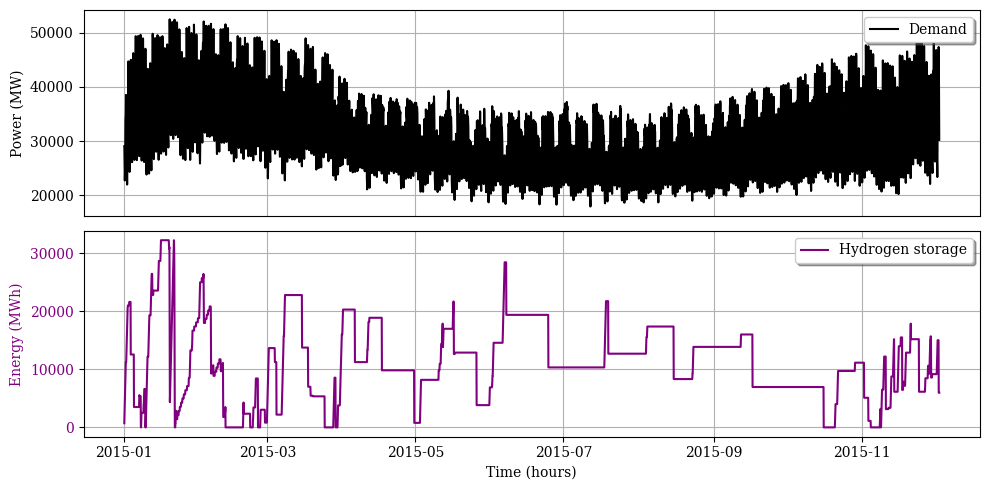

In [38]:
# Plot a week with hydrogen storage on a secondary axis
num_hours_week = 7 * 24
num_weeks = 4 * 12
hours = pd.date_range(start="2015-01-01", periods=num_hours_week * num_weeks, freq='H')

demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values
hydrogen = network.stores_t.e['H2 Tank'][hours].values

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 1]})

# First subplot: Energy production and demand
axs[0].plot(hours, demand, color='black', label='Demand')
# axs[0].plot(hours, onshore_wind, color='blue', label='Onshore wind')
# axs[0].plot(hours, solar, color='orange', label='Solar')
# axs[0].plot(hours, gas_ccgt, color='red', label='Gas (CCGT)')
# axs[0].plot(hours, offshore_wind, color='green', label='Offshore wind')
# axs[0].plot(hours, nuclear, color='brown', label='Nuclear')
axs[0].legend(fancybox=True, shadow=True, loc='upper right')
axs[0].set_ylabel('Power (MW)')
axs[0].grid(True)

# Remove x-axis ticks and labels for the first subplot
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Second subplot: Hydrogen storage
axs[1].plot(hours, hydrogen, color='purple', label='Hydrogen storage')
axs[1].set_xlabel('Time (hours)')
axs[1].set_ylabel('Energy (MWh)', color='purple')
axs[1].tick_params(axis='y', labelcolor='purple')
axs[1].legend(fancybox=True, shadow=True, loc='upper right')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_38744\3693302089.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')


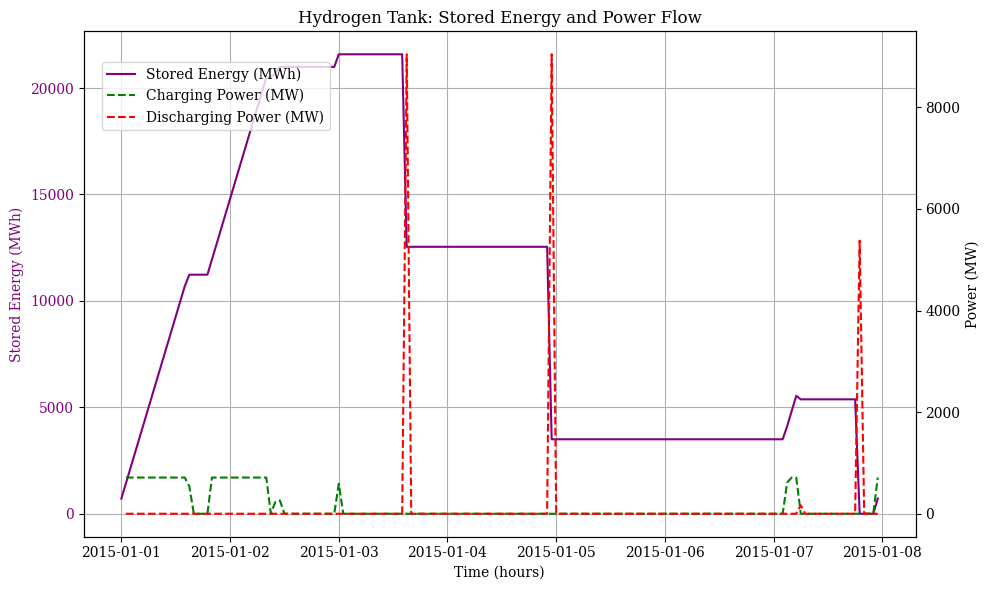

In [11]:
# Selection of plotted hours
num_hours_week = 24 * 7
hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')

# Hydrogen storage data
stored_energy = network.stores_t.e['H2 Tank']
delta_energy = stored_energy.diff()

# Define charging and discharging
charging = (delta_energy > 0) * delta_energy
discharging = (delta_energy < 0) * delta_energy

# Filter data for the selected hours
stored_energy = stored_energy[hours].values
charging = charging[hours].values
discharging = discharging[hours].values

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: stored energy
ax1.plot(hours, stored_energy, color='purple', label='Stored Energy (MWh)')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Stored Energy (MWh)', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.grid(True)

# Right y-axis: charging and discharging power
ax2 = ax1.twinx()
ax2.plot(hours, charging, label='Charging Power (MW)', linestyle='--', color='green')
ax2.plot(hours, -discharging, label='Discharging Power (MW)', linestyle='--', color='red')  # Use -discharging to make values positive
ax2.set_ylabel('Power (MW)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Hydrogen Tank: Stored Energy and Power Flow')
plt.tight_layout()
plt.show()

Text(0.5, 1.07, 'Electricity mix')

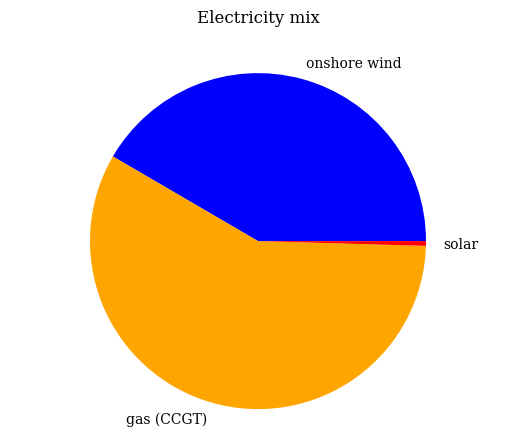

In [12]:
labels = ['onshore wind',
          'gas (CCGT)', 
          'solar']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['solar'].sum(),
]

colors=['blue', 'orange', 'red']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

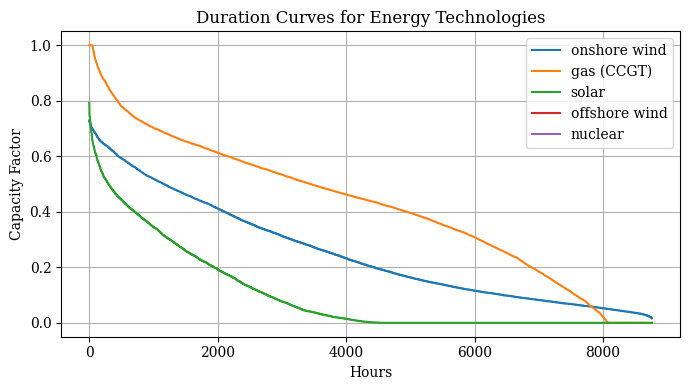

In [13]:
# Capacity factor calculation
capacity_factors = {
    "onshore wind": network.generators_t.p['onshorewind'] / network.generators.p_nom_opt['onshorewind'],
    "gas (CCGT)": network.generators_t.p['CCGT'] / network.generators.p_nom_opt['CCGT'],
    "solar": network.generators_t.p['solar'] / network.generators.p_nom_opt['solar'],
    "offshore wind": network.generators_t.p['offshorewind'] / network.generators.p_nom_opt['offshorewind'],
    "nuclear": network.generators_t.p['nuclear'] / network.generators.p_nom_opt['nuclear']
}

# Sorting data for duration curve plot
duration_curves = {
    tech: np.sort(data)[::-1]
    for tech, data in capacity_factors.items()
}

# Plotting the duration curves
plt.figure(figsize=(7, 4))
for tech, data in duration_curves.items():
    plt.plot(data, label=tech)

plt.title('Duration Curves for Energy Technologies')
plt.xlabel('Hours')
plt.ylabel('Capacity Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
